In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
# -*- coding: utf-8 -*-

from tensorflow.keras.layers import Conv3D, ConvLSTM2D, Conv3DTranspose, Input, BatchNormalization, Activation
from tensorflow.keras.models import Model
import tensorflow as tf
from PIL import ImageFont, ImageDraw, Image
import numpy as np
import cv2
import sys
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import glob
import pickle
import os
import matplotlib.pyplot as plt

# def BuildModel(input_shape=(227, 227, 50, 1)):
#     input = Input(shape=input_shape)

#     # Spatial Encoder
#     spatial_enc = Conv3D(filters=128, kernel_size=(11,11,1), strides=(4,4,1), padding='valid')(input)
#     spatial_enc = BatchNormalization()(spatial_enc)
#     spatial_enc = Activation('relu')(spatial_enc)
#     spatial_enc = Conv3D(filters=64, kernel_size=(5,5,1), strides=(2,2,1), padding='valid')(spatial_enc)
#     spatial_enc = BatchNormalization()(spatial_enc)
#     spatial_enc = Activation('relu')(spatial_enc)

#     # Temporal Encoder
#     temporal_enc = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.4, recurrent_dropout=0.3, return_sequences=True)(spatial_enc)
#     temporal_enc = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.3, return_sequences=True)(temporal_enc)

#     # Temporal Decoder
#     temporal_dec = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.5, return_sequences=True)(temporal_enc)

#     # Spatial Decoder
#     spatial_dec = Conv3DTranspose(filters=64, kernel_size=(5,5,1), strides=(2,2,1), padding='valid')(temporal_dec)
#     spatial_dec = BatchNormalization()(spatial_dec)
#     spatial_dec = Activation('relu')(spatial_dec)
#     spatial_dec = Conv3DTranspose(filters=128, kernel_size=(11,11,1), strides=(4,4,1), padding='valid')(spatial_dec)
#     spatial_dec = BatchNormalization()(spatial_dec)
#     spatial_dec = Activation('sigmoid')(spatial_dec)

#     autoencoder = Model(inputs=input, outputs=spatial_dec)
#     encoder = Model(inputs=input, outputs=temporal_enc)

#     encoded_shape = encoder.output_shape[1:]
#     encoded_input = Input(shape=encoded_shape)

#     decoder_output = autoencoder.layers[-4](encoded_input)
#     for layer in autoencoder.layers[-3:]:
#         decoder_output = layer(decoder_output)
#     decoder = Model(inputs=encoded_input, outputs=decoder_output)

#     autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['accuracy'])

#     return autoencoder, encoder, decoder
def BuildModel(input_shape=(227, 227, 50, 1)):
    input = Input(shape=input_shape)

    # Spatial Encoder
    spatial_enc = Conv3D(filters=128, kernel_size=(11,11,1), strides=(4,4,1), padding='valid')(input)
    spatial_enc = BatchNormalization()(spatial_enc)
    spatial_enc = Activation('relu')(spatial_enc)
    print("spactial enc1", spatial_enc)
    spatial_enc = Conv3D(filters=64, kernel_size=(5,5,1), strides=(2,2,1), padding='valid')(spatial_enc)
    spatial_enc = BatchNormalization()(spatial_enc)
    spatial_enc = Activation('relu')(spatial_enc)
    print("spactial enc2", spatial_enc)
    # Temporal Encoder
    temporal_enc = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.4, return_sequences=True)(spatial_enc)
    # temporal_enc = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.3, return_sequences=True)(temporal_enc)
    print("temporal enc", temporal_enc)
    # Temporal Decoder
    temporal_dec = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.5, return_sequences=True)(temporal_enc)
    print("temporal dec", temporal_dec)
    # Spatial Decoder
    spatial_dec = Conv3DTranspose(filters=64, kernel_size=(5,5,1), strides=(2,2,1), padding='valid')(temporal_dec)
    spatial_dec = BatchNormalization()(spatial_dec)
    spatial_dec = Activation('relu')(spatial_dec)
    print("spactial dec1", spatial_dec)
    spatial_dec = Conv3DTranspose(filters=128, kernel_size=(11,11,1), strides=(4,4,1), padding='valid')(spatial_dec)
    spatial_dec = BatchNormalization()(spatial_dec)
    spatial_dec = Activation('relu')(spatial_dec)
    print("spactial dec2", spatial_dec)
    spatial_dec = Conv3DTranspose(filters=1, kernel_size=(1,1,1), strides=(1,1,1), padding='valid')(spatial_dec)
    # spatial_dec = BatchNormalization()(spatial_dec)
    # spatial_dec = Activation('sigmoid')(spatial_dec)
    # spatial_dec = np.expand_dims(spatial_dec, axis=0)
    print("spactial dec3", spatial_dec)

    autoencoder = Model(inputs=input, outputs=spatial_dec)
    encoder = Model(inputs=input, outputs=temporal_enc)

    encoded_shape = encoder.output_shape[1:]
    print("encoded_shape", encoded_shape)
    encoded_input = Input(shape=encoded_shape)

    decoder_output = autoencoder.layers[-7](encoded_input)
    print('-4layer', autoencoder.layers[-7])
    print("decoder_output", decoder_output)
    print("autoencoder.layers", autoencoder.layers)
    for layer in autoencoder.layers[-6:]:
        decoder_output = layer(decoder_output)
        print("decoder_output", decoder_output)
    decoder = Model(inputs=encoded_input, outputs=decoder_output)

    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['accuracy'])

    return autoencoder, encoder, decoder



def TF_GPUsetup(GB=4):
    if type(GB) != int:
        raise TypeError('Type of Parameter `GB` must be `int` and it should be 1 GB less than your GPU memory')
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.set_memory_growth(gpu, True)
            tf.config.set_virtual_device_configuration(
                gpus[0],
                [tf.config.VirtualDeviceConfiguration(memory_limit=1024 * GB)]
            )
            print(f"Configured to use up to {GB} GB of GPU memory.")
        except RuntimeError as e:
            print(e)
    print('\nTensorFlow GPU installed: ' + str(tf.test.is_built_with_cuda()))
    print('Is TensorFlow using GPU: ' + str(tf.config.list_physical_devices('GPU')))

def PrepareData(X_train, frame_count=50, height=227, width=227, channels=1):
    num_samples = X_train.shape[0]
    num_samples -= num_samples % frame_count
    X_train = X_train[:num_samples]
    X_train = X_train.reshape(-1, frame_count, height, width)
    X_train = np.transpose(X_train, (0, 2, 3, 1))
    X_train = np.expand_dims(X_train, axis=4)
    print("preparedataaaaaaaaaaaaaa: ",X_train.shape)
    return X_train

def GetTrainData(name):
    if type(name) != str:
        raise TypeError('Provide a valid name of `string` datatype, to the `.npy` file.')
    if '.npy' not in name:
        name += '.npy'
    X_train = np.load(name)
    print("--------", X_train.ndim)
    print("------------", X_train.shape)
    return PrepareData(X_train)

def OverlayText2Img(img, text):
    cv2_im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_im = Image.fromarray(cv2_im_rgb)
    draw = ImageDraw.Draw(pil_im)
    font = ImageFont.truetype("arial.ttf", 40)
    draw.text((0, 0), text, font=font)
    im_pros = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)
    return im_pros

def ShowVideo(cap, v_frame, text):
    v_frame = OverlayText2Img(v_frame, text)
    cv2.imshow('Real Time Anomaly Detection - Github.com/irdanish11', v_frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        if cap is not None:
            cap.release()
        cv2.destroyAllWindows()
        raise KeyboardInterrupt('Real Time Anomaly Detection Stopped due to Keyboard Interrupt!')

def PrintInline(string):
    sys.stdout.write('\r' + string)
    sys.stdout.flush()

def ImgProcess(frame, shape=(227,227)):
    frame = cv2.resize(frame, shape)
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray = np.dot(frame, rgb_weights)
    gray = (gray - gray.mean()) / gray.std()
    gray = np.clip(gray, 0, 1)
    return gray

def Img_LstArr(img_lst, re_shape=(227, 227, 10)):
    img_arr = np.array(img_lst)
    img_arr.resize(re_shape)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = np.expand_dims(img_arr, axis=4)
    return img_arr

def MSE(x1, x2):
    diff = x1 - x2
    a, b, c, d, e = diff.shape
    n_samples = a * b * c * d * e
    sq_diff = diff ** 2
    Sum = sq_diff.sum()
    dist = np.sqrt(Sum)
    mean_dist = dist / n_samples
    return mean_dist

def ListCopy(lst):
    new_lst = []
    for item_lst in lst:
        for item in item_lst:
            new_lst.append(item)
    return new_lst

def TrainModel(X_train, autoencoder_model, encoder_model, decoder_model, ckpt_name, hist_name, ckpt_path, epochs, batch_size):
    os.makedirs(ckpt_path, exist_ok=True)
    ckpt = ModelCheckpoint(os.path.join(ckpt_path, ckpt_name), monitor='loss', save_best_only=True)
    e_stop = EarlyStopping(monitor='loss', patience=10)
    History = autoencoder_model.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, callbacks=[ckpt, e_stop])
    encoder_model.save_weights(os.path.join(ckpt_path, 'encoder_weights.weights.h5'))
    decoder_model.save_weights(os.path.join(ckpt_path, 'decoder_weights.weights.h5'))
    with open(os.path.join(ckpt_path, hist_name), "wb") as f:
        pickle.dump(History.history, f)
    return History.history


def DisplayFrames(X_train):
    X_train = X_train[0, :, :, :, 0]

    num_frames = X_train.shape[2]
    fig, axes = plt.subplots(1, num_frames, figsize=(num_frames * 2, 2))

    for i in range(num_frames):
        ax = axes[i]
        ax.imshow(X_train[:, :, i], cmap='gray')
        ax.axis('off')  # Hide the axes

    plt.show()

def LoadModelWeights(encoder_model, decoder_model, ckpt_path):
    encoder_model.load_weights(os.path.join(ckpt_path, 'encoder_weights.weights.h5'))
    decoder_model.load_weights(os.path.join(ckpt_path, 'decoder_weights.weights.h5'))

def EncodeData(encoder_model, input_data):
    return encoder_model.predict(input_data)

def DecodeData(decoder_model, encoded_data):
    return decoder_model.predict(encoded_data)

def TestModel(encoder_model, decoder_model, test_data):
    encoded_data = EncodeData(encoder_model, test_data)
    reconstructed_data = DecodeData(decoder_model, encoded_data)
    return reconstructed_data

if __name__ == "__main__":
    input_shape = (227, 227, 50, 1)
    X_train = GetTrainData("/content/drive/MyDrive/Avenue_Dataset/Train_Data/normalized_batch_0.npy")
    # DisplayFrames(X_train)
    autoencoder_model, encoder_model, decoder_model = BuildModel(input_shape)

    ckpt_name = "autoencoder_checkpoint.keras"
    hist_name = "training_history.pkl"
    ckpt_path = "./checkpoints"
    epochs = 1500
    batch_size = 4

    TrainModel(X_train, autoencoder_model, encoder_model, decoder_model, ckpt_name, hist_name, ckpt_path, epochs, batch_size)

    LoadModelWeights(encoder_model, decoder_model, ckpt_path)

    test_data = GetTrainData("/content/drive/MyDrive/Avenue_Dataset/Train_Data/normalized_batch_0.npy")

    encoded_output = EncodeData(encoder_model, test_data)
    print(f"Encoder output shape: {encoded_output.shape}")

    # reconstructed_data = DecodeData(decoder_model, encoded_output)
    # print("Reconstructed data shape:", reconstructed_data.shape) #(1,111,111,50,128)

-------- 3
------------ (50, 227, 227)
preparedataaaaaaaaaaaaaa:  (1, 227, 227, 50, 1)
spactial enc1 <KerasTensor shape=(None, 55, 55, 50, 128), dtype=float32, sparse=False, name=keras_tensor_75>
spactial enc2 <KerasTensor shape=(None, 26, 26, 50, 64), dtype=float32, sparse=False, name=keras_tensor_78>
temporal enc <KerasTensor shape=(None, 26, 26, 50, 64), dtype=float32, sparse=False, name=keras_tensor_79>
temporal dec <KerasTensor shape=(None, 26, 26, 50, 64), dtype=float32, sparse=False, name=keras_tensor_80>
spactial dec1 <KerasTensor shape=(None, 55, 55, 50, 64), dtype=float32, sparse=False, name=keras_tensor_83>
spactial dec2 <KerasTensor shape=(None, 227, 227, 50, 128), dtype=float32, sparse=False, name=keras_tensor_86>
spactial dec3 <KerasTensor shape=(None, 227, 227, 50, 1), dtype=float32, sparse=False, name=keras_tensor_87>
encoded_shape (26, 26, 50, 64)
-4layer <Conv3DTranspose name=conv3d_transpose_9, built=True>
decoder_output <KerasTensor shape=(None, 55, 55, 50, 64), dty

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Encoder output shape: (1, 26, 26, 50, 64)


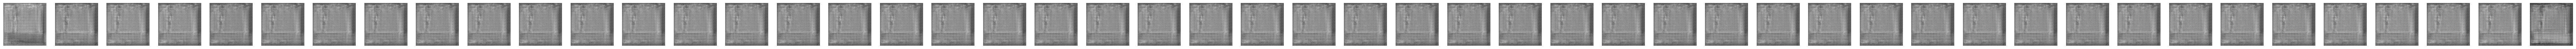

In [ ]:
DisplayFrames(reconstructed_data)

In [ ]:
reconstructed_data = DecodeData(decoder_model, encoded_output)
print("Reconstructed data shape:", reconstructed_data.shape) #(1,111,111,50,128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Reconstructed data shape: (1, 227, 227, 50, 1)


In [ ]:
def load_cover_image(cover_image_path, target_shape=(227, 227)):
    image = cv2.imread(cover_image_path) #(1040,1356,3)
    print("iamge", image.shape)
    image = cv2.resize(image, (26,26))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=-1)  # (1040, 1356, 1)
    image = np.expand_dims(image, axis=0)  # (1, 1040, 1356, 1)
    repeated_images = np.repeat(image, 50, axis=-1)  #(1, 1040, 1356, 50)
    repeated_images = np.expand_dims(repeated_images, axis=-1)  #(1, 1040, 1356, 50, 1)
    return repeated_images

def save_stego_image(stego_image, filename):
    np.save(filename, stego_image)

def load_stego_image(filename):
    return np.load(filename)

def EmbedData(latent_representation, cover_image):
    batch_size, h, w, t, c = latent_representation.shape  # (1, 26, 26, 50, 64)

    latent_flat = latent_representation.reshape(batch_size, -1)  # Flatten latent representation

    latent_normalized = (latent_flat - latent_flat.min()) / (latent_flat.max() - latent_flat.min())  # Normalize

    latent_reshaped = latent_normalized.reshape(batch_size, h, w, t, c)  # Reshape to original latent shape

    # Blend latent data into cover image without changing dimensions
    stego_image = cover_image + latent_reshaped  # Element-wise addition
    stego_image = np.clip(stego_image, 0, 1)  # Ensure pixel values are within valid range [0, 1]

    return stego_image, latent_representation.shape



def DebedData(stego_image, original_latent_shape, cover_image):
    # Extract latent data by subtracting the cover image
    latent_reshaped = stego_image - cover_image
    latent_reshaped = np.clip(latent_reshaped, 0, 1)  # Ensure values are within valid range

    # Reshape to the original latent dimensions
    latent_reshaped = latent_reshaped.reshape(original_latent_shape)

    # Denormalize (this step might require additional information, so adjust as needed)
    latent_denormalized = latent_reshaped * (latent_reshaped.max() - latent_reshaped.min()) + latent_reshaped.min()

    return latent_denormalized


cover_image_path = "/content/0008.png"
cover_image = load_cover_image(cover_image_path)

stego_image, latent_shape = EmbedData(encoded_output, cover_image)
print("stego_image", stego_image.shape)
save_stego_image(stego_image, "stego_image.npy")
loaded_stego_image = load_stego_image("stego_image.npy")
print("latent shape.....", latent_shape)
# get_latent = DebedData(loaded_stego_image, latent_shape)

iamge (1356, 2040, 3)
stego_image (1, 26, 26, 50, 64)
latent shape..... (1, 26, 26, 50, 64)


In [ ]:
def load_cover_image(cover_image_path, target_shape=(227, 227)):
    image = cv2.imread(cover_image_path) #(1040,1356,3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=-1)  # (1040, 1356, 1)
    image = np.expand_dims(image, axis=0)  # (1, 1040, 1356, 1)
    repeated_images = np.repeat(image, 50, axis=-1)  (1, 1040, 1356, 50)
    repeated_images = np.expand_dims(repeated_images, axis=-1)  #(1, 1040, 1356, 50, 1)
    return repeated_images

def save_stego_image(stego_image, filename):
    np.save(filename, stego_image)

def load_stego_image(filename):
    return np.load(filename)

def EmbedData(latent_representation, cover_image):
    # Extract dimensions of the latent representation
    batch_size, h, w, t, c = latent_representation.shape  # (1, 26, 26, 50, 64)

    # Flatten the latent representation
    latent_flat = latent_representation.reshape(batch_size, -1)  # Shape: (1, 26*26*50*64)

    # Normalize the flattened latent representation
    latent_normalized = (latent_flat - latent_flat.min()) / (latent_flat.max() - latent_flat.min())

    # Extract dimensions of the cover image
    cover_height, cover_width, cover_channels, cover_frames, _ = cover_image.shape  # (1, 1040, 1356, 50, 1)

    # Ensure that the cover image can accommodate the latent representation
    # Here we need to reshape the latent_normalized back to its original shape for concatenation
    latent_reshaped = latent_normalized.reshape(batch_size, h, w, t, c)  # Shape: (1, 26, 26, 50, 64)

    # Concatenate the cover image and the reshaped latent representation along the channel axis
    stego_image = np.concatenate([cover_image, latent_reshaped], axis=-1)  # Concatenate along the last dimension

    return stego_image, latent_representation.shape


def DebedData(stego_image, original_latent_shape):
    cover_height, cover_width, cover_channels = stego_image.shape

    latent_extracted = stego_image[:, :, :cover_channels]

    latent_flat = latent_extracted.reshape(-1)
    latent_reshaped = latent_flat.reshape(original_latent_shape)

    latent_denormalized = latent_reshaped * (latent_reshaped.max() - latent_reshaped.min()) + latent_reshaped.min()

    return latent_denormalized

cover_image_path = "/content/0006.png"
cover_image = load_cover_image(cover_image_path)

stego_image, latent_shape = EmbedData(encoded_output, cover_image)
save_stego_image(stego_image, "stego_image.npy")
loaded_stego_image = load_stego_image("stego_image.npy")
print("latent shape.....", latent_shape)
# get_latent = DebedData(loaded_stego_image, latent_shape)

In [ ]:
reconstructed_data = DecodeData(decoder_model, get_latent)
print("Reconstructed data shape:", reconstructed_data.shape)

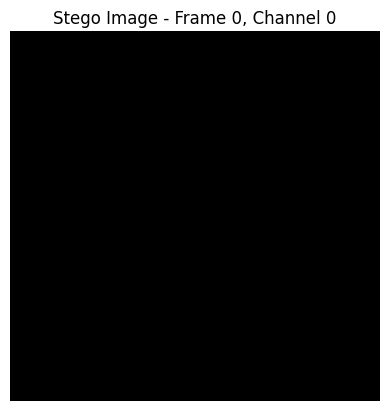

In [ ]:
frame_index = 0
channel_index = 0

# Extract the image for visualization
single_frame = stego_image[0, :, :, frame_index, channel_index]  # Shape: (26, 26)

# Plot the image using matplotlib
plt.imshow(single_frame, cmap='gray')
plt.title(f'Stego Image - Frame {frame_index}, Channel {channel_index}')
plt.axis('off')
plt.show()

In [ ]:
'''import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load and preprocess the image
image = cv2.imread('/content/0006.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
image = np.expand_dims(image, axis=-1)  # Shape: (1040, 1356, 1)
image = np.expand_dims(image, axis=0)  # Shape: (1, 1040, 1356, 1)

# Manually replicate the grayscale image 50 times along the new axis
repeated_images = np.repeat(image, 50, axis=-1)  # Shape: (1, 1040, 1356, 50)

# Reshape the tensor to add the last channel
repeated_images = np.expand_dims(repeated_images, axis=-1)  # Shape: (1, 1040, 1356, 50, 1)

# Verify the final shape
print(repeated_images.shape)  # Should be (1, 1040, 1356, 50, 1)

# Show one of the repeated images using plt
plt.imshow(repeated_images[0, :, :, 0, 0], cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()
'''

In [ ]:
def cnn_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    # First Convolutional Block
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Convert to grayscale by reducing the channels
    model.add(tf.keras.layers.Conv2D(1, (1, 1), activation='linear'))

    # Resize to (26, 26)
    model.add(tf.keras.layers.Conv2D(1, (3, 3), activation='linear'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Repeat the image 50 times along the new axis
    model.add(tf.keras.layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 50])))

    return model

def load_cover_image_with_cnn(cover_image_path, target_shape=(26, 26)):
    # Load and preprocess the image
    image = cv2.imread(cover_image_path)  # Shape: (1040, 1356, 3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)  # Shape: (1, 1040, 1356, 3)

    # Create a CNN model to process the image
    model = cnn_model(input_shape=(image.shape[1], image.shape[2], image.shape[3]))

    # Run the image through the CNN
    processed_image = model.predict(image)

    # Add an extra axis to match the desired shape (1, H, W, 50, 1)
    processed_image = np.expand_dims(processed_image, axis=-1)

    return processed_image

cover_image_path = "/content/wallpaper.jpg"
cover_image = load_cover_image_with_cnn(cover_image_path)

print("Processed cover image shape:", cover_image.shape)